In [1]:
from datasets.idda import IDDADataset
from datasets.idda import showIDDAsample
from models.deeplabv3 import deeplabv3_mobilenetv2
from torch.utils.data import DataLoader
import datasets.ss_transforms as sstr

In [2]:
import numpy as np
p=0.5
np.random.binomial(1,p)

1

In [3]:
train_transform=sstr.Compose([sstr.RandomCompose([sstr.Resize((2,3))],0.2),sstr.ToTensor()])
train_transform=sstr.Compose([sstr.RandomCrop(),sstr.ToTensor()])
#sstr.RandomResizedCrop((512,928),scale=(0.5,2))


In [4]:
iddaTrain=IDDADataset('data/idda',fileName='train.txt',transform=train_transform)
print(f'Training set size: {iddaTrain.__len__()}')
iddaTestSame=IDDADataset('data/idda',fileName='test_same_dom.txt')
print(f'Test set size for same domain: {iddaTestSame.__len__()}')
iddaTestDiff=IDDADataset('data/idda',fileName='test_diff_dom.txt')
print(f'Test set size for diff domain: {iddaTestDiff.__len__()}')

Training set size: 600
Test set size for same domain: 120
Test set size for diff domain: 120


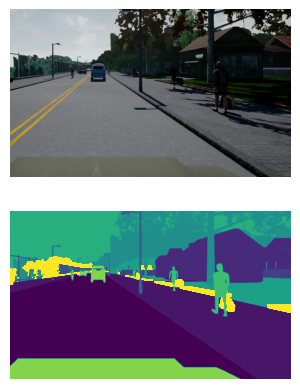

In [30]:
#showing a random sample
showIDDAsample(iddaTrain[140])

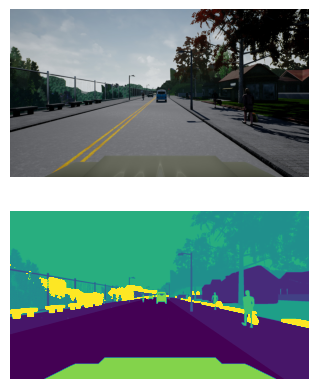

In [5]:
train_transform=sstr.Compose([sstr.ToTensor()])
iddaTrain=IDDADataset('data/idda',fileName='train.txt',transform=train_transform)
showIDDAsample(iddaTrain[140])

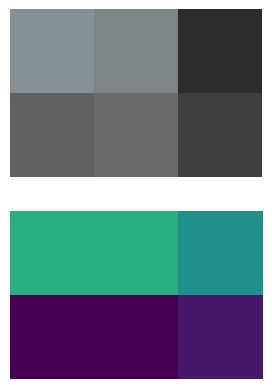

In [6]:
train_transform=sstr.Compose([sstr.Resize((2,3)),sstr.ToTensor()])
iddaTrain=IDDADataset('data/idda',fileName='train.txt',transform=train_transform)
showIDDAsample(iddaTrain[140])

In [9]:
from client import Client
from server import Server
from models.deeplabv3 import deeplabv3_mobilenetv2
def createCentralizedServer(model,metrics,train_transform,test_transform,num_epochs,batch_size,root='data/idda'):
    iddaTrain=IDDADataset(root,fileName='train.txt',transform=train_transform,client_name='Centralized server')
    iddaTestSame=IDDADataset(root,fileName='test_same_dom.txt',transform=test_transform,client_name='IDDA same domain')
    iddaTestDiff=IDDADataset(root,fileName='test_diff_dom.txt',transform=test_transform,client_name='IDDA different domain')
    train_clients=[Client(dataset=iddaTrain,model=model,num_epochs=num_epochs,batch_size=batch_size)]
    test_clients=[Client(dataset=iddaTestDiff,model=model,test_client=True,num_epochs=num_epochs,batch_size=batch_size),Client(dataset=iddaTestSame,model=model,test_client=True,num_epochs=num_epochs,batch_size=batch_size)]
    return Server(train_clients=train_clients,test_clients=test_clients,model=model,metrics=metrics,num_rounds=1,clients_per_round=1)

In [10]:
#Parameters that MUST be changed
initialModel=deeplabv3_mobilenetv2(num_classes=16)
metrics='provaAcaso'
test_tr=sstr.Compose([sstr.RandomResizedCrop((512,928),scale=(0.5,2)),sstr.ToTensor()])
train_tr=sstr.Compose([sstr.RandomResizedCrop((512,928),scale=(0.5,2)),sstr.ToTensor()])
central=createCentralizedServer(initialModel,metrics,train_tr,test_tr,41,24)

TypeError: Client.__init__() got an unexpected keyword argument 'num_epochs'

In [11]:
import json
def createServerStep2(model,metrics,train_transform,test_transform,num_epochs,batch_size,num_rounds,clients_per_round,root='data/idda'):
    f=open(root+'/train.json')
    clients=json.load(f)
    train_clients=[]
    for key in clients:
        train_clients.append(Client(dataset=IDDADataset(root,list_samples=clients[key],transform=train_transform,client_name=key),model=model,num_epochs=num_epochs,batch_size=batch_size))
    
    #Not clear which test set to use
    iddaTestSame=IDDADataset(root,fileName='test_same_dom.txt',transform=test_transform,client_name='IDDA same domain')
    iddaTestDiff=IDDADataset(root,fileName='test_diff_dom.txt',transform=test_transform,client_name='IDDA different domain')
    test_clients=[Client(dataset=iddaTestDiff,model=model,test_client=True,num_epochs=num_epochs,batch_size=batch_size),Client(dataset=iddaTestSame,model=model,test_client=True,num_epochs=num_epochs,batch_size=batch_size)]
    return Server(train_clients=train_clients,test_clients=test_clients,model=model,metrics=metrics,num_rounds=num_rounds,clients_per_round=clients_per_round)

In [12]:
server2=createServerStep2(model=initialModel,metrics=metrics,train_transform=train_tr,test_transform=test_tr,num_epochs=23,num_rounds=10,batch_size=10,clients_per_round=4)

TypeError: Client.__init__() got an unexpected keyword argument 'num_epochs'

In [13]:
print(initialModel.parameters())

<generator object Module.parameters at 0x000001E14F299E00>


In [16]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([10, 3, 512, 928])
Labels batch shape: torch.Size([10, 512, 928])


In [23]:
from torch import nn,optim
from utils.utils import MeanReduction
model=deeplabv3_mobilenetv2(16)
print(model.state_dict()['backbone.0.0.weight'])
for bid,(images,labels) in enumerate(train_loader):
    print(bid)
    outputs=model(images)
    optimizer.zero_grad()
    criterion = nn.CrossEntropyLoss(ignore_index=255, reduction='none')
    reduction = MeanReduction()
    optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=0)
    a=criterion(outputs['out'],labels)
    loss=reduction(a,labels)
    loss.backward()
    optimizer.step()
    print(model.state_dict()['backbone.0.0.weight'])

tensor([[[[-8.3003e-03,  1.4036e-01, -9.8734e-02],
          [ 4.4346e-02, -3.9299e-01,  3.6993e-01],
          [-4.1812e-02, -6.4314e-01,  6.6024e-01]],

         [[ 6.0020e-02,  1.3627e-01, -2.2879e-01],
          [ 7.2245e-02, -7.2179e-01,  6.7224e-01],
          [-2.2645e-02, -1.1691e+00,  1.1658e+00]],

         [[-3.4703e-02,  1.4519e-01, -1.4297e-01],
          [ 1.1727e-02, -1.5689e-01,  1.4347e-01],
          [-2.2541e-02, -2.7720e-01,  3.3339e-01]]],


        [[[ 4.4847e-02, -1.2480e-02, -7.5773e-02],
          [ 5.5217e-02,  2.4012e-01,  7.6300e-02],
          [ 7.6142e-02,  5.7174e-01,  8.5220e-02]],

         [[-1.3514e-02, -9.1512e-02, -1.9465e-02],
          [-4.6759e-02,  1.5686e-01, -7.1573e-02],
          [ 2.8590e-02,  5.4538e-01, -2.2906e-01]],

         [[-4.5977e-02, -9.0650e-02,  2.2273e-02],
          [-4.9955e-03,  1.5115e-01, -2.8668e-02],
          [-5.3420e-02,  3.4969e-01, -3.2084e-01]]],


        [[[-5.3509e-02,  4.5083e-03, -8.3901e-02],
          [-2.1

c:\Users\ollob\anaconda3\envs\mldl23fl_6\lib\site-packages\torchvision\transforms\functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


0
tensor([[[[-8.3470e-03,  1.4026e-01, -9.8832e-02],
          [ 4.4602e-02, -3.9278e-01,  3.7012e-01],
          [-4.1602e-02, -6.4296e-01,  6.6041e-01]],

         [[ 5.9993e-02,  1.3622e-01, -2.2885e-01],
          [ 7.2399e-02, -7.2166e-01,  6.7237e-01],
          [-2.2543e-02, -1.1690e+00,  1.1658e+00]],

         [[-3.4661e-02,  1.4523e-01, -1.4295e-01],
          [ 1.1891e-02, -1.5673e-01,  1.4362e-01],
          [-2.2418e-02, -2.7708e-01,  3.3351e-01]]],


        [[[ 4.4839e-02, -1.2461e-02, -7.5750e-02],
          [ 5.5200e-02,  2.4013e-01,  7.6316e-02],
          [ 7.6122e-02,  5.7175e-01,  8.5238e-02]],

         [[-1.3542e-02, -9.1515e-02, -1.9464e-02],
          [-4.6792e-02,  1.5685e-01, -7.1573e-02],
          [ 2.8556e-02,  5.4538e-01, -2.2906e-01]],

         [[-4.5989e-02, -9.0638e-02,  2.2288e-02],
          [-5.0119e-03,  1.5116e-01, -2.8656e-02],
          [-5.3436e-02,  3.4970e-01, -3.2083e-01]]],


        [[[-5.3539e-02,  4.5012e-03, -8.3912e-02],
          [-2

KeyboardInterrupt: 

In [ ]:
class Args:
    def __init__(self,num_rounds,num_epochs,clients_per_round,hnm=False,lr=0.05,bs=4,wd=0,m=0.9):
        #Rounds 
        self.num_rounds=num_rounds
        #Epochs per client for each round
        self.num_epochs=num_epochs
        #Clients selected per round
        self.clients_per_round=clients_per_round
        #Use HardMargin
        self.hnm=hnm
        #Batch size
        self.bs=bs
        #Learning rate
        self.lr=lr
        #Weight decay
        self.wd=wd
        #Momentum
        self.m=m

In [ ]:
args=Args(10,10,10)

In [3]:
from utils.stream_metrics import StreamSegMetrics
num_classes=16
metrics = {
            'eval_train': StreamSegMetrics(num_classes, 'eval_train'),
            'test_same_dom': StreamSegMetrics(num_classes, 'test_same_dom'),
            'test_diff_dom': StreamSegMetrics(num_classes, 'test_diff_dom')
        }
for metric in metrics.values():
    metric.reset()